In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
from collections import Counter
from TrackReconstruction_functions import *

pd.options.mode.chained_assignment = None  # Disable the warning

pressure=1
# diffusion="5.0percent"
diffusion="0.5percent"


hits_true = pd.read_hdf(f"../data/NEXT100/beersheba_99_208Tl.h5", "MC/hits")
hits      = pd.read_hdf(f"../data/NEXT100/beersheba_99_208Tl.h5", "/DECO/Events")
hits.rename(columns={'event': 'event_id', "E":"energy", "X": "x", "Y":"y", "Z":"z"}, inplace=True)
hits["event_id"] = hits["event_id"]/2


hit_tot_energy = hits.groupby('event_id')['energy'].sum().reset_index(name='hit_tot_energy')
hit_tot_energy = hit_tot_energy[hit_tot_energy.hit_tot_energy > 1]
hits = hits[hits.event_id.isin(hit_tot_energy.event_id.unique())]
hits_true = hits_true[hits_true.event_id.isin(hit_tot_energy.event_id.unique())]

display(hits)

event_list = hits.event_id.unique()

print(hits.event_id.unique())
print(hits.event_id.unique())

,event_id,npeak,x,y,z,energy,Xpeak,Ypeak,time,nsipm,Xrms,Yrms
7866,980003.0,0.0,-187.125,373.575,237.418223,0.000040,-211.259727,375.778745,1.960007e+12,0,0,0
7867,980003.0,0.0,-187.125,374.575,237.418223,0.000043,-211.259727,375.778745,1.960007e+12,0,0,0
7868,980003.0,0.0,-187.125,375.575,237.418223,0.000042,-211.259727,375.778745,1.960007e+12,0,0,0
7869,980003.0,0.0,-187.125,376.575,237.418223,0.000038,-211.259727,375.778745,1.960007e+12,0,0,0
7870,980003.0,0.0,-186.125,372.575,237.418223,0.000042,-211.259727,375.778745,1.960007e+12,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2539888,980316.0,0.0,310.875,300.575,624.841547,0.000051,299.186409,316.477041,1.960633e+12,0,0,0
2539889,980316.0,0.0,310.875,301.575,624.841547,0.000050,299.186409,316.477041,1.960633e+12,0,0,0
2539890,980316.0,0.0,310.875,302.575,624.841547,0.000039,299.186409,316.477041,1.960633e+12,0,0,0
2539891,980316.0,0.0,311.875,300.575,624.841547,0.000026,299.186409,316.477041,1.960633e+12,0,0,0


[980003. 980004. 980006. 980008. 980026. 980027. 980031. 980033. 980042.
 980049. 980055. 980057. 980058. 980061. 980065. 980068. 980071. 980073.
 980076. 980080. 980082. 980083. 980086. 980089. 980100. 980104. 980105.
 980111. 980112. 980119. 980122. 980125. 980126. 980130. 980134. 980138.
 980139. 980140. 980142. 980143. 980144. 980149. 980150. 980151. 980153.
 980155. 980156. 980158. 980160. 980177. 980178. 980180. 980194. 980199.
 980203. 980204. 980205. 980215. 980216. 980218. 980219. 980220. 980227.
 980228. 980236. 980238. 980240. 980242. 980249. 980251. 980252. 980254.
 980256. 980265. 980271. 980272. 980273. 980275. 980282. 980284. 980285.
 980296. 980297. 980298. 980302. 980303. 980304. 980307. 980309. 980316.]
[980003. 980004. 980006. 980008. 980026. 980027. 980031. 980033. 980042.
 980049. 980055. 980057. 980058. 980061. 980065. 980068. 980071. 980073.
 980076. 980080. 980082. 980083. 980086. 980089. 980100. 980104. 980105.
 980111. 980112. 980119. 980122. 980125. 980126. 9

In [109]:
eid=320000
eid=event_list[4]

data = hits[hits.event_id ==eid]
data_true = hits_true[hits_true.event_id == int(eid)]
display(data_true)

,event_id,particle_id,hit_id,x,y,z,time,energy,label
7151,980026,22,0,310.779114,279.968231,649.314636,0.622153,0.000022,ACTIVE
7152,980026,24,0,310.779022,279.968140,649.314636,0.622183,0.000046,ACTIVE
7153,980026,23,0,310.269501,279.309967,649.868713,0.625545,0.002237,ACTIVE
7154,980026,23,1,309.789368,278.615295,650.400818,0.628930,0.001564,ACTIVE
7155,980026,23,2,309.329254,277.875916,650.891724,0.632321,0.004332,ACTIVE
...,...,...,...,...,...,...,...,...,...
8039,980026,48,6,285.697601,250.430450,689.927795,0.824749,0.001970,ACTIVE
8040,980026,48,7,285.706451,250.421631,689.932617,0.825028,0.001780,ACTIVE
8041,980026,48,8,285.708466,250.414597,689.928040,0.825239,0.002948,ACTIVE
8042,980026,48,9,285.709747,250.413422,689.926331,0.825332,0.001707,ACTIVE


In [110]:

Diff_smear, energy_threshold, diff_scale_factor, radius_sf, voxel_sf, Tortuosity_dist  = InitializeParams(pressure, diffusion)
# voxel_sf=1.1
energy_threshold=0
Diff_smear=0.8
print("Diffussion smear is: ",        Diff_smear,            "mm/sqrt(cm)")
print("Energy threshold is: ",        1000*energy_threshold, "keV")
print("diffision scale factor is: ",  diff_scale_factor)
print("Radius scale factor is: ",     radius_sf)
print("Voxel scale factor is: ",      voxel_sf)
print("Tortuosity distance scale is:", Tortuosity_dist)

mean_sigma = round(diff_scale_factor*Diff_smear*np.sqrt(0.1*data.z.mean()))


# Calculate the detector half-length
det_size = int(1300) 

# Create the bins ---- 
xbw  = mean_sigma
xmin = -det_size - mean_sigma/2 
xmax = det_size  + mean_sigma/2

ybw  = mean_sigma
ymin = -det_size - mean_sigma/2 
ymax = det_size  + mean_sigma/2

# This shifts the z pos of the events so 0 is at anode
# can set this to zero
z_shift = det_size
# z_shift = 0

zbw=mean_sigma
zmin=-det_size + z_shift - mean_sigma/2 
zmax=det_size + z_shift + mean_sigma/2

# bins for x, y, z
xbins = np.arange(xmin, xmax+xbw, xbw)
ybins = np.arange(ymin, ymax+ybw, ybw)
zbins = np.arange(zmin, zmax+zbw, zbw)

# center bins for x, y, z
xbin_c = xbins[:-1] + xbw / 2
ybin_c = ybins[:-1] + ybw / 2
zbin_c = zbins[:-1] + zbw / 2

Diffussion smear is:  0.8 mm/sqrt(cm)
Energy threshold is:  0 keV
diffision scale factor is:  4
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 105.0


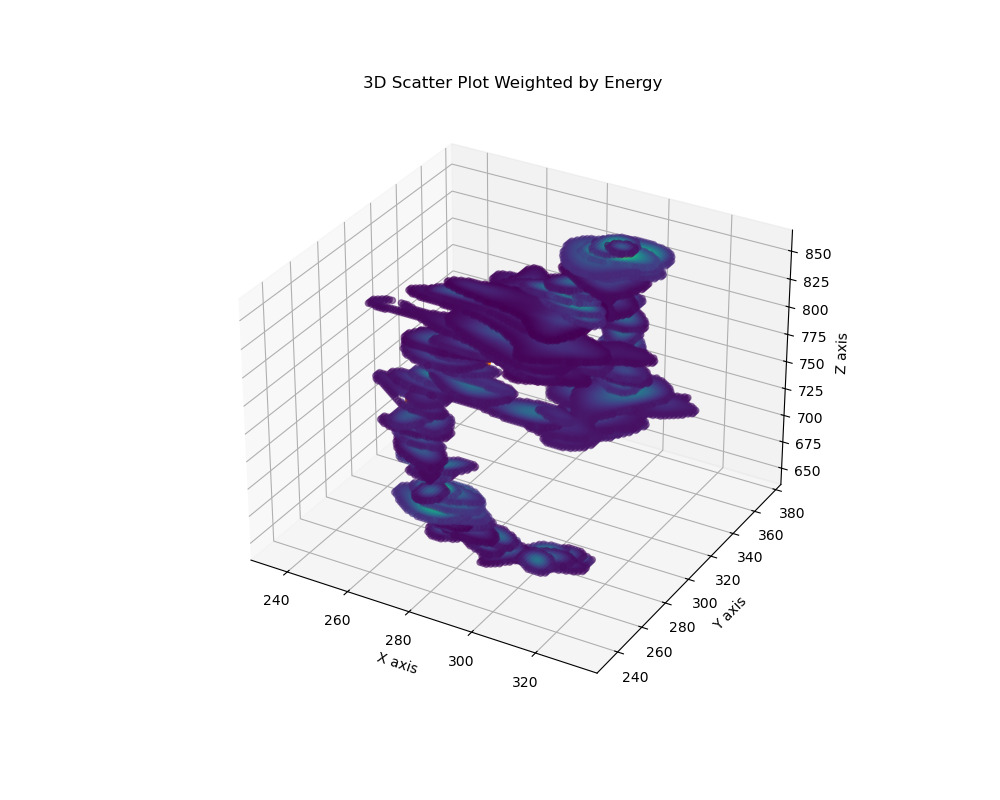

In [111]:
%matplotlib widget 

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Normalize the energy values for the colors
cmap = plt.get_cmap('viridis')
norm = plt.Normalize(data.energy.min(), data.energy.max())
colors = cmap(norm(data.energy))


# Plot the scatter plot
scatter = ax.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o', c="DarkOrange")

# ax.scatter(data_true['x'], data_true['y'], data_true['z']+3000, marker='o', c="DarkRed")

# Add color bar to indicate energy values
mappable = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
mappable.set_array(data.energy)
# cbar = plt.colorbar(mappable)
# cbar.set_label('Energy')

# Set labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_title('3D Scatter Plot Weighted by Energy')

plt.show()

In [112]:
# There seems to be a duplicate row sometimes
data = data.drop_duplicates()

# display(data)
data = data[['event_id','x', 'y', 'z',"energy"]]

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(data)

,event_id,x,y,z,energy
0,980026.0,234.875,300.575,800.639963,0.000024
1,980026.0,234.875,301.575,800.639963,0.000026
2,980026.0,234.875,302.575,800.639963,0.000026
3,980026.0,234.875,303.575,800.639963,0.000026
4,980026.0,234.875,304.575,800.639963,0.000024
...,...,...,...,...,...
31482,980026.0,330.875,323.575,759.652163,0.000035
31483,980026.0,331.875,319.575,759.652163,0.000034
31484,980026.0,331.875,320.575,759.652163,0.000035
31485,980026.0,331.875,321.575,759.652163,0.000035


,event_id,x,y,z,energy
0,980026.0,234.875,300.575,800.639963,0.000024
1,980026.0,234.875,301.575,800.639963,0.000026
2,980026.0,234.875,302.575,800.639963,0.000026
3,980026.0,234.875,303.575,800.639963,0.000026
4,980026.0,234.875,304.575,800.639963,0.000024
...,...,...,...,...,...
31482,980026.0,330.875,323.575,759.652163,0.000035
31483,980026.0,331.875,319.575,759.652163,0.000034
31484,980026.0,331.875,320.575,759.652163,0.000035
31485,980026.0,331.875,321.575,759.652163,0.000035


Mean z: 779.5490656453458  diffusion =  28
Mean Sigma:  28
Total groups created: 1


,x,y,z,energy,group_id
0,254.875,301.575,800.639963,0.034262,0
1,262.875,279.575,762.754913,0.067764,0
2,268.875,321.575,806.802544,0.131991,0
3,268.875,289.575,784.894359,0.150007,0
4,269.875,258.575,740.810766,0.088796,0
5,277.875,346.575,803.722041,0.056763,0
6,281.875,248.575,709.318838,0.250961,0
7,285.875,303.575,800.639963,0.210672,0
8,285.875,279.575,769.112859,0.031475,0
9,289.875,329.575,816.313378,0.214183,0


27 2.2360062096637665


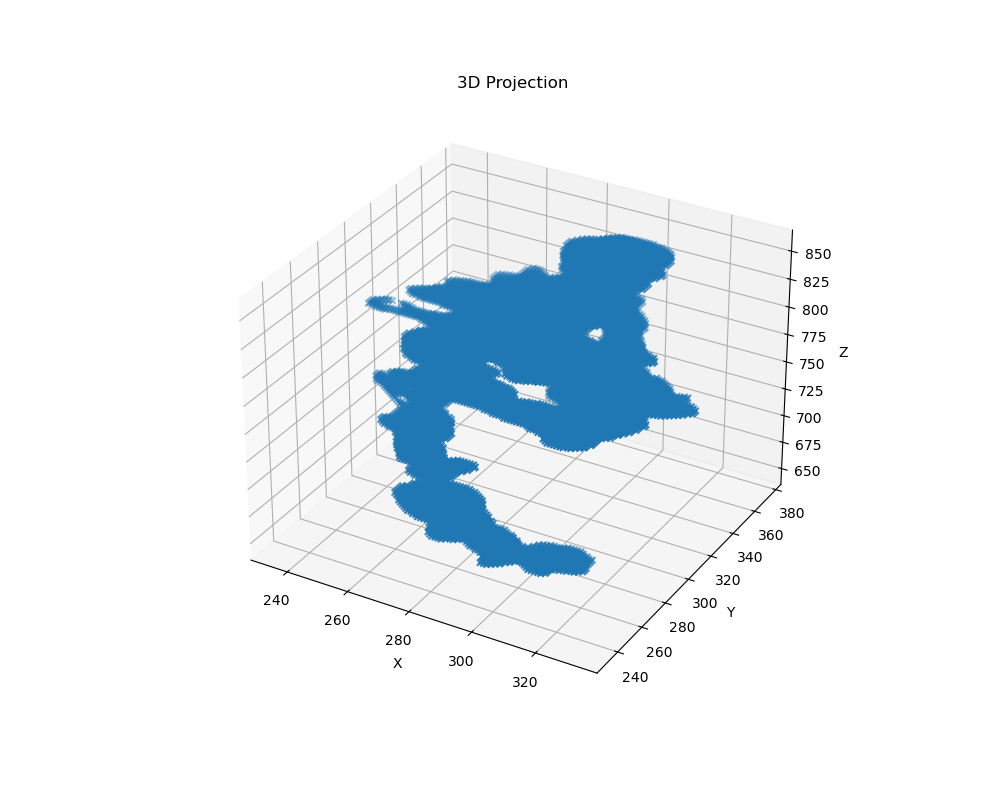

In [113]:

display(data)

print("Mean z:", data.z.mean(), " diffusion = ", mean_sigma)
print("Mean Sigma: ", mean_sigma)


# Apply grouping
# voxel size and parameters
voxel_size = mean_sigma  # mm
threshold = voxel_size*voxel_sf

data_copy = data.copy()
df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, threshold)

# If we have too many groups then bump up the voxel size since the track was broken too much
if (len(df_merged.group_id.unique()) > 10):
    print("Running grouping again")
    df_merged = GroupHits(data_copy, xmin, ymin, zmin, voxel_size, voxel_size*(voxel_sf+1))

df_merged = CutandRedistibuteEnergy(df_merged, energy_threshold)


# Apply clustering
node_centers_df = []

for gid in sorted(df_merged.group_id.unique()):
    temp_df = df_merged[df_merged.group_id == gid]
    temp_df.reset_index(drop=True, inplace=True)
    node_centers_df.append(Cluster(temp_df, mean_sigma))

node_centers_df = pd.concat(node_centers_df, ignore_index=True)

display(node_centers_df)
print(len(node_centers_df), node_centers_df.energy.sum())

# -------

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for gid in sorted(df_merged.group_id.unique()):
    # ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.01)
    # ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o')
    temp_df = df_merged[df_merged.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')



ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()



In [114]:


databin = node_centers_df.copy()
databin["event_id"] = eid

# Now lets bin the data
databin['x_smear'] = pd.cut(x=databin['x'], bins=xbins,labels=xbin_c, include_lowest=True)
databin['y_smear'] = pd.cut(x=databin['y'], bins=ybins,labels=ybin_c, include_lowest=True)
databin['z_smear'] = pd.cut(x=databin['z'], bins=zbins,labels=zbin_c, include_lowest=True)



# Drop rows with any NaN values
databin = databin.dropna()

# Dictionary to store results
aggregated_data = {}

# Iterate through the DataFrame row by row
for _, row in databin.iterrows():
    key = (row['event_id'], row['x_smear'], row['y_smear'], row['z_smear'], row['group_id'])
    
    if key not in aggregated_data:
        # Initialize the aggregation for a new group
        aggregated_data[key] = {
            'x_sum': row['x'],
            'y_sum': row['y'],
            'z_sum': row['z'],
            'energy_sum': row['energy'],
            'group_id' : row['group_id'],
            'count': 1
        }
    else:
        # Update existing group values
        aggregated_data[key]['x_sum'] += row['x']
        aggregated_data[key]['y_sum'] += row['y']
        aggregated_data[key]['z_sum'] += row['z']
        aggregated_data[key]['energy_sum'] += row['energy']
        aggregated_data[key]['group_id'] = row['group_id']
        aggregated_data[key]['count'] += 1

# Convert aggregated data into a DataFrame
result = []
for key, values in aggregated_data.items():
    event_id, x_smear, y_smear, z_smear, group_id = key
    result.append({
        'event_id': event_id,
        'x_smear': x_smear,
        'y_smear': y_smear,
        'z_smear': z_smear,
        'x': values['x_sum'] / values['count'],   # Mean x
        'y': values['y_sum'] / values['count'],   # Mean y
        'z': values['z_sum'] / values['count'],   # Mean z
        'energy': values['energy_sum'],           # Sum energy
        'group_id' : int(group_id)
    })

# Create final DataFrame
databin = pd.DataFrame(result)

# then sort it based on the x,y,z
# databin = databin.sort_values(by=['x', "y", "z"]).reset_index(drop=True)


display(databin)


,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,980026.0,268.0,296.0,812.0,254.875,301.575,800.639963,0.034262,0
1,980026.0,268.0,268.0,756.0,262.875,279.575,762.754913,0.067764,0
2,980026.0,268.0,324.0,812.0,268.875,321.575,806.802544,0.131991,0
3,980026.0,268.0,296.0,784.0,268.875,289.575,784.894359,0.150007,0
4,980026.0,268.0,268.0,728.0,275.875,258.075,736.076513,0.092122,0
5,980026.0,268.0,352.0,812.0,277.875,346.575,803.722041,0.056763,0
6,980026.0,268.0,240.0,700.0,281.875,248.575,709.318838,0.250961,0
7,980026.0,296.0,296.0,812.0,292.375,299.075,800.639963,0.254060,0
8,980026.0,296.0,268.0,756.0,296.875,280.075,765.158198,0.058121,0
9,980026.0,296.0,324.0,812.0,296.375,320.575,808.476670,0.244326,0


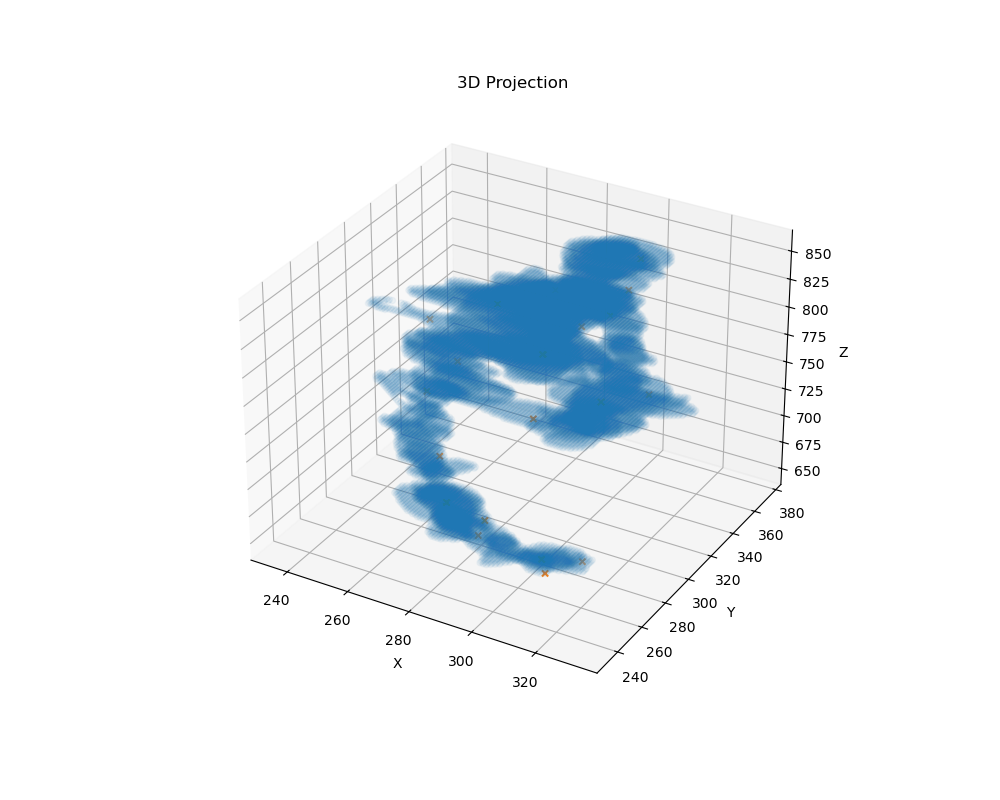

In [115]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(data['x'], data['y'], data['z'], marker='o',alpha=0.05)
# ax.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',color="Teal")


for gid in sorted(databin.group_id.unique()):

    temp_df = databin[databin.group_id == gid]
    ax.scatter(temp_df['x'], temp_df['y'], temp_df['z'], marker='x')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()

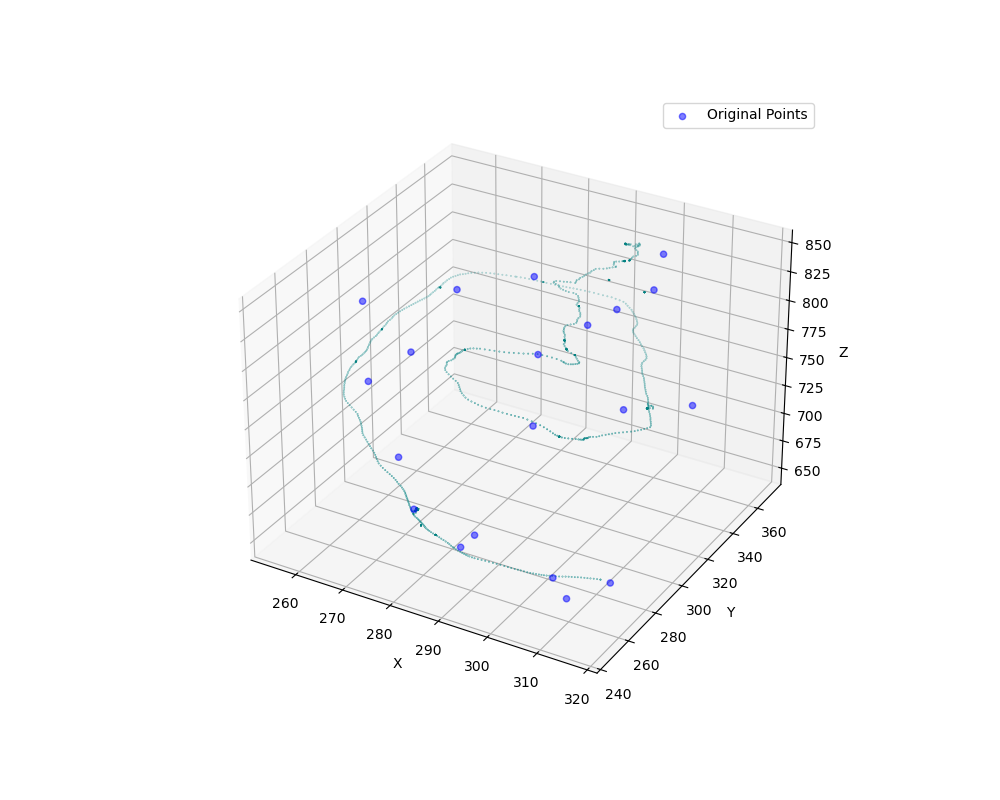

In [116]:

# Plot the original points and the polynomial fit
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(databin.x, databin.y,databin.z, color='blue', label='Original Points', alpha=0.5)
ax.scatter(data_true['x'], data_true['y'], data_true['z'],s=0.1 ,marker='o',color="Teal")

# Labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [117]:
display(databin)

databin.to_hdf("../data/test/test.h5", "MC/hits")

,event_id,x_smear,y_smear,z_smear,x,y,z,energy,group_id
0,980026.0,268.0,296.0,812.0,254.875,301.575,800.639963,0.034262,0
1,980026.0,268.0,268.0,756.0,262.875,279.575,762.754913,0.067764,0
2,980026.0,268.0,324.0,812.0,268.875,321.575,806.802544,0.131991,0
3,980026.0,268.0,296.0,784.0,268.875,289.575,784.894359,0.150007,0
4,980026.0,268.0,268.0,728.0,275.875,258.075,736.076513,0.092122,0
5,980026.0,268.0,352.0,812.0,277.875,346.575,803.722041,0.056763,0
6,980026.0,268.0,240.0,700.0,281.875,248.575,709.318838,0.250961,0
7,980026.0,296.0,296.0,812.0,292.375,299.075,800.639963,0.254060,0
8,980026.0,296.0,268.0,756.0,296.875,280.075,765.158198,0.058121,0
9,980026.0,296.0,324.0,812.0,296.375,320.575,808.476670,0.244326,0


/var/folders/tr/r0bv1gl52_vb7v8bswkb_z0nb301gc/T/ipykernel_9944/1135446823.py:3: FutureWarning: Starting with pandas version 3.0 all arguments of to_hdf except for the argument 'path_or_buf' will be keyword-only.
  databin.to_hdf("../data/test/test.h5", "MC/hits")


Diffussion smear is:  0.507 mm/sqrt(cm)
Energy threshold is:  0.4 keV
diffision scale factor is:  4
Radius scale factor is:  7
Voxel scale factor is:  2.1
Tortuosity distance scale is: 105.0
Median distance to the closest row: 22.949254896920696
Distances to iterate over [  1  12  23  35  46  58  69  80  92 103 115 126 137 149 160]
Dist Thresh 100.716
Pass Flag: True
The primary track is:  0
    event_id        x        y           z    energy  group_id  id  primary  \
0   980026.0  302.875  352.825  844.705378  0.288003         0  13        1   
1   980026.0  305.875  334.575  835.391222  0.004142         0  15        1   
2   980026.0  296.375  320.575  808.476670  0.244326         0  11        1   
3   980026.0  292.375  299.075  800.639963  0.254060         0   8        1   
4   980026.0  317.375  322.075  762.790481  0.061412         0  19        1   
5   980026.0  306.875  309.575  759.652163  0.268104         0  16        1   
6   980026.0  296.875  280.075  765.158198  0.058121

,event_id,x,y,z,energy,group_id,id,primary,trkID,cumulative_distance,angle,Tortuosity,Squiglicity
id,,,,,,,,,,,,,
13,980026.0,302.875,352.825,844.705378,0.288003,0,13,1,0,0.000000,0.000000,1.077339,0.251131
15,980026.0,305.875,334.575,835.391222,0.004142,0,15,1,0,20.707873,137.479755,1.077339,0.251131
11,980026.0,296.375,320.575,808.476670,0.244326,0,11,1,0,52.498486,43.479665,1.499566,0.748030
8,980026.0,292.375,299.075,800.639963,0.254060,0,8,1,0,75.729155,41.872741,1.619451,0.885136
19,980026.0,317.375,322.075,762.790481,0.061412,0,19,1,0,126.587618,104.603545,2.236190,1.754680
16,980026.0,306.875,309.575,759.652163,0.268104,0,16,1,0,143.211368,120.666391,3.805715,2.911535
12,980026.0,296.875,280.075,765.158198,0.058121,0,12,1,0,174.843099,29.763524,4.855161,2.912600
1,980026.0,262.875,279.575,762.754913,0.067764,0,1,1,0,208.931598,71.535033,2.963478,2.887612
2,980026.0,268.875,289.575,784.894359,0.150007,0,2,1,0,233.954690,107.902283,3.627667,2.983451


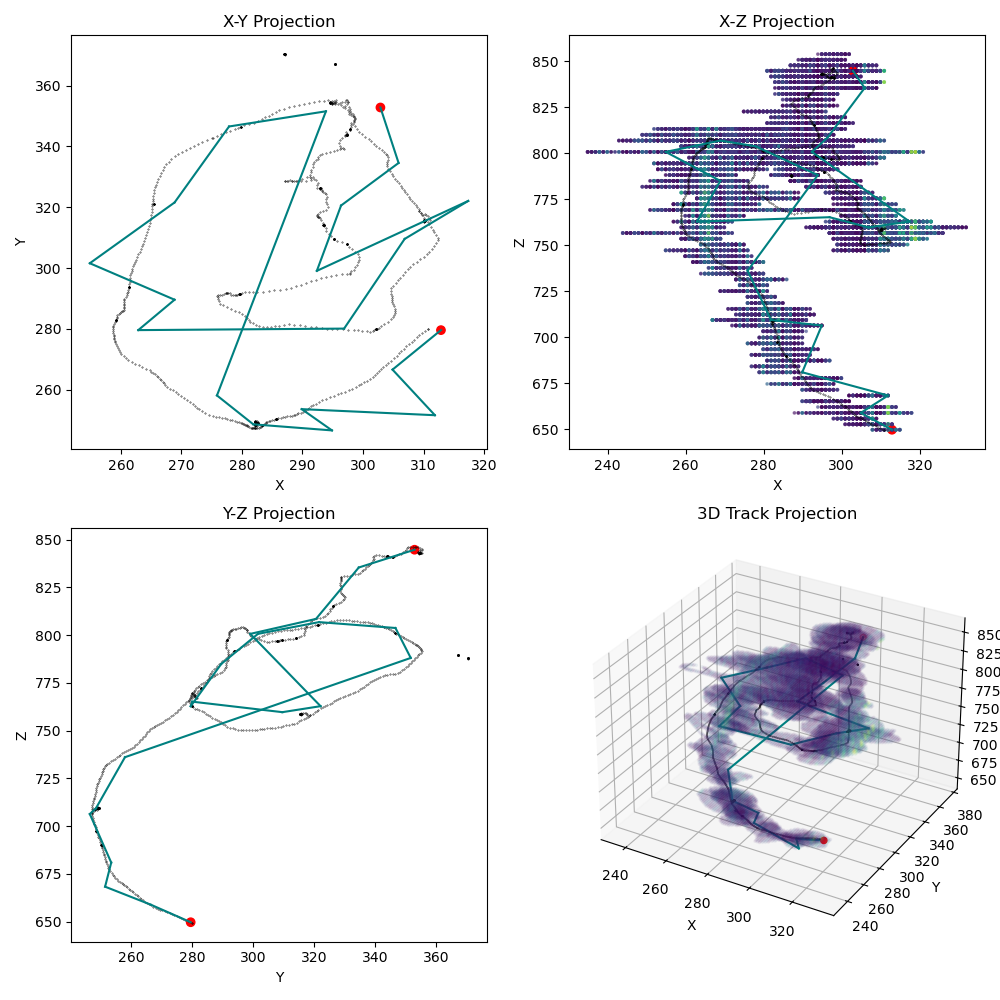

In [122]:
# Apply the tracking reconstruction

# df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy"]], 0, 1, "5percent", 0)
df, Tracks, connected_nodes, connection_count, pass_flag = RunTracking(databin[["event_id", "x", "y", "z", "energy", "group_id"]], 0, pressure, diffusion, 0)

df.index = df.id

display(df)

# Create subplots
fig = plt.figure(figsize=(10, 10))

axs = [fig.add_subplot(2, 2, i + 1) for i in range(3)]

# Plot xy projection
plot_tracks(axs[0], df['x'], df['y'], connection_count, 'X', 'Y', Tracks)
# axs[0].scatter(data.x, data.y, c=colors, marker='o', alpha=0.5,s=3)
axs[0].scatter(data_true['x'], data_true['y'], marker='o',c="k", s=0.1)

# Plot xz projection
plot_tracks(axs[1], df['x'], df['z'], connection_count, 'X', 'Z', Tracks)
axs[1].scatter(data.x, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[1].scatter(data_true['x'], data_true['z'], marker='o',c="k", s=0.1)

# Plot yz projection
plot_tracks(axs[2], df['y'], df['z'], connection_count, 'Y', 'Z', Tracks)
# axs[2].scatter(data.y, data.z, c=colors, marker='o', alpha=0.5,s=3)
axs[2].scatter(data_true['y'], data_true['z'], marker='o',c="k", s=0.1)


# 3D Projection
ax_3D = fig.add_subplot(2, 2, 4, projection='3d')
plot_tracks_3D(ax_3D, df['x'], df['y'], df['z'], connection_count, Tracks)
ax_3D.scatter(data_true['x'], data_true['y'], data_true['z'], marker='o',c="k", s=0.1)
ax_3D.scatter(data.x, data.y, data.z, c=colors, marker='o', alpha=0.05,s=3)

plt.tight_layout()
plt.show()

In [119]:
temp_meta = GetTrackdf(df, Tracks, 500/pressure, 180/pressure, 200/pressure, pressure) # scale these params inversely with the pressure
temp_meta = UpdateTrackMeta(temp_meta, df, 100/pressure) # Merge deltas and brems that are near the blobs in the metadata
display(temp_meta)

,event_id,trkID,primary,start,end,length,energy,blob1,blob2,blob1R,blob2R,Tortuosity1,Tortuosity2,Squiglicity1,Squiglicity2,label
0,980026.0,0,1,13,18,573.2,2.236006,2.107512,1.699535,2.107512,1.943861,2.310109,1.352017,1.387749,0.627262,Primary


Text(0, 0.5, 'RMS')

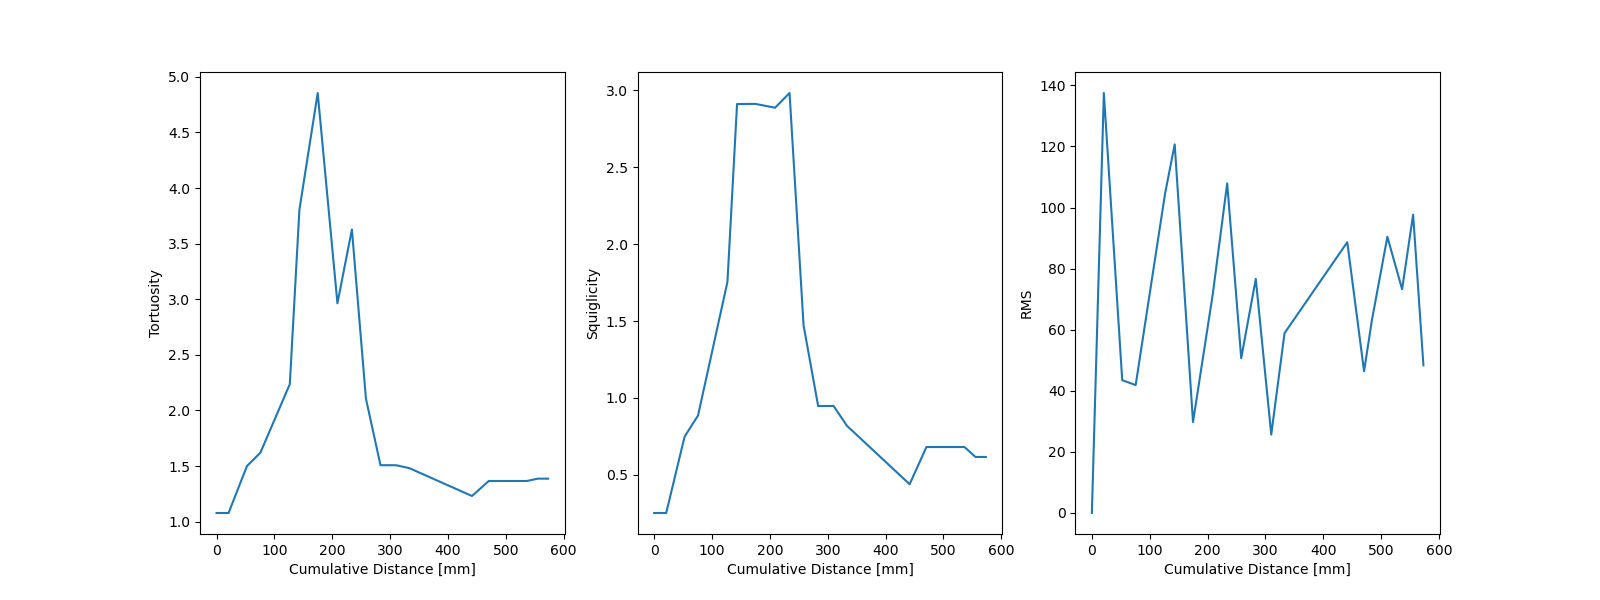

In [120]:

fig, axs = plt.subplots(1, 3, figsize=(16, 6))

axs[0].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Tortuosity"])
axs[0].set_xlabel("Cumulative Distance [mm]")
axs[0].set_ylabel("Tortuosity")

axs[1].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["Squiglicity"])
axs[1].set_xlabel("Cumulative Distance [mm]")
axs[1].set_ylabel("Squiglicity")


axs[2].plot(df[df.primary == 1].cumulative_distance, df[df.primary == 1]["angle"])
axs[2].set_xlabel("Cumulative Distance [mm]")
axs[2].set_ylabel("RMS")